In [1]:
# wow, very many playgrounds
# this one is to just strictly work on optimization

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import editdistance
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
sys.path.append('/usr/local/ViennaRNA/lib/python3.7/site-packages/')
%reload_ext autoreload
%autoreload 2
# from utils.sequence_utils import *
from models.Theoretical_models import *
from models.Noise_wrapper import *
from exploration_strategies.CE import *
# from exploration_strategies.RL_explorers_modify import *
from utils.landscape_utils import *
from models.RNA_landscapes import *
from models.Multi_dimensional_model import *
import RNA

In [2]:
import torch
from torch import nn
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F

In [468]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RAA="UGCA" #alphabet
length=40
np.random.seed(0)
wt='CACGCCCGCUAAUAGGUACCACUAAUUUGAUUGUUCGUGG' #generate_random_sequences(length,1,alphabet=RAA)[0]
print(wt)
#make a simple folding landscape starting at wt
landscape1=RNA_landscape(wt)
noise_alpha=1
virtual_per_measure_ratio=15
temperature=0.1
# there are multiple abstract "noise models" you can use, or you can try to train your own model, using skM
noisy_landscape_CE=Noise_wrapper(landscape1,noise_alpha=noise_alpha)
noisy_landscape_RL=Noise_wrapper(landscape1,noise_alpha=noise_alpha)
noisy_landscape_RL_multiple=Noise_wrapper(landscape1,noise_alpha=noise_alpha)
#noisy_landscape=Gaussian_noise_landscape(base_landscape,noise_alpha=0.15)
#noisy_landscape=DF_noise_landscape(base_landscape,noise_alpha=0.5)
batch_size = 10
initial_genotypes=list(set([wt]+[generate_random_mutant(wt,0.05,RAA) for i in range(batch_size*10)]))[:batch_size]
len(initial_genotypes)

CACGCCCGCUAAUAGGUACCACUAAUUUGAUUGUUCGUGG


10

# CE baseline

In [457]:
def run_CE(initial_genotypes, batch_size, generations):
    noisy_landscape_CE.reset()
    noisy_landscape_CE.measure_true_landscape(initial_genotypes)
    noisy_landscape_CE.natural_mode=False
    noisy_landscape_CE.local_mode=False
    noisy_landscape_CE.cost

    eCE=CE(noisy_landscape_CE,initial_genotypes,wt,\
           alphabet=RAA,batch_size=batch_size,recomb_rate=0.0, \
           temperature=temperature,virtual_screen=virtual_per_measure_ratio)

    news=[]
    CE_top_seqs = []
    
    print(noisy_landscape_CE.cost,eCE.top_sequence[-1][0])
    while noisy_landscape_CE.cost<generations*batch_size:
        news.append(eCE.pick_action())

        print(noisy_landscape_CE.cost,eCE.top_sequence[-1][0])
        CE_top_seqs += [(noisy_landscape_CE.cost, eCE.top_sequence[-1][0])]
        news=[]
        
    return CE_top_seqs

In [449]:
batch_size = 10
generations = 10
CE_top_seqs = run_CE(initial_genotypes, batch_size, generations)

10 0.11882353389964384
20 0.13529411764705881
30 0.183529416252585
40 0.19176469690659467
50 0.19176469690659467
60 0.2035294027889476
70 0.2482352986055262
80 0.2482352986055262
90 0.2517647013944738
100 0.25647057925953587


# SINGLE AGENT RL

In [420]:
import numpy as np
import random
import bisect
from utils.sequence_utils import translate_string_to_one_hot


def renormalize_moves(one_hot_input,rewards_output):
    """ensures that staying in place gives no reward"""
    zero_current_state=(one_hot_input-1)*-1
    return np.multiply(rewards_output,zero_current_state)

def walk_away_renormalize_moves(one_hot_input, one_hot_wt, rewards_output):
    """ensures that moving toward wt is also not useful"""
    zero_current_state=(one_hot_input-1)*-1
    zero_wt=((one_hot_wt-1)*-1)
    zero_conservative_moves=np.multiply(zero_wt,zero_current_state)
    return np.multiply(rewards_output,zero_conservative_moves)

def get_all_singles_fitness(model,sequence,alphabet):
    prob_singles=np.zeros((len(alphabet),len(sequence)))
    for i in range(len(sequence)):
        for j in range(len(alphabet)):
            putative_seq=sequence[:i]+alphabet[j]+sequence[i+1:]
           # print (putative_seq)
            prob_singles[j][i]=model.get_fitness(putative_seq)
    return prob_singles

def sample_greedy(matrix, output=None):
    i,j=matrix.shape
    max_arg=np.argmax(matrix)
    y=max_arg%j
    x=int(max_arg/j)
    if not(type(output)==np.array):
        output=np.zeros((i,j))
    output[x][y]=matrix[x][y]
    return output

def sample_greedy_k(matrix, k, output=None):
    i,j = matrix.shape
    max_args = np.argsort(matrix.flatten())[-k:]
    if not(type(output)==np.array):
        outputs = [np.zeros((i,j)) for _ in range(k)]
    else:
        outputs = [output for _ in range(k)]
    for ixk in range(k):
        y = max_args[ixk]%j
        x = int(max_args[ixk]/j)
        outputs[ixk][x][y] = matrix[x][y]
    return outputs

def sample_multi_greedy(matrix):
    n = 5 # the number of base positions to greedily change
    max_args = np.argpartition(matrix.flatten(), -n)[-n:]
    i,j=matrix.shape
    output=np.zeros((i,j))
    for max_arg in max_args:
        y=max_arg%j
        x=int(max_arg/j)
        output[x][y]=matrix[x][y]
    return output

def sample_random(matrix, output = None):
    i,j=matrix.shape
    non_zero_moves=np.nonzero(matrix)
   # print (non_zero_moves)
    k=len(non_zero_moves)
    l=len(non_zero_moves[0])
    if k!=0 and l!=0:
        rand_arg=random.choice([[non_zero_moves[alph][pos] for alph in range(k)] for pos in range(l)])
    else:
        rand_arg=[random.randint(0,i-1),random.randint(0,j-1)]
    #print (rand_arg)
    y=rand_arg[1]
    x=rand_arg[0]
    if not(type(output)==np.array):
        output=np.zeros((i,j))
    output[x][y]=matrix[x][y]
    return output   
    
def construct_mutant_from_sample(pwm_sample, one_hot_base):
    one_hot=np.zeros(one_hot_base.shape)
    one_hot+=one_hot_base
    nonzero = np.nonzero(pwm_sample)
    nonzero = list(zip(nonzero[0], nonzero[1]))
    for nz in nonzero: # this can be problematic for non-positive fitnesses
        i, j = nz
        one_hot[:,j]=0
        one_hot[i,j]=1
    return one_hot

def make_one_hot_train_test(genotypes,model,alphabet,split=0.0):
    genotypes_one_hot=[translate_string_to_one_hot(genotype,alphabet) for genotype in genotypes]
    genotype_fitnesses=[get_all_singles_fitness(model,genotype,alphabet) for genotype in genotypes]
    train_x=[]
    test_x=[]
    train_y=[]
    test_y=[]
    if split>0: #check this to avoid calling the randomizer if not required
        for x,y in zip(genotypes_one_hot,genotype_fitnesses):
                if random.random()<split:
                    test_x.append(x)
                    test_y.append(y)
                else:
                    train_x.append(x)
                    train_y.append(y)
        train_x=np.stack(train_x)
        train_y=np.stack(train_y)
        test_y=np.stack(test_y)
        test_x=np.stack(test_x)
        return train_x,train_y,test_x,test_y
    else:
        train_x=np.stack(genotypes_one_hot)
        train_y=np.stack(genotype_fitnesses)

        return train_x,train_y,test_x,test_y

In [888]:
from collections import deque
# from utils.RL_utils import *
from utils.sequence_utils import translate_one_hot_to_string,generate_random_mutant
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class RL_agent_QN():

    def __init__(self,model, start_sequence,alphabet,gamma=0.9,memory_size=1000, device = "cpu"):
        self.model=model
        self.alphabet=alphabet
        self.state=translate_string_to_one_hot(start_sequence,self.alphabet)
        self.seq_size=len(start_sequence)
        self.actor=build_model(self.seq_size,len(self.alphabet), device)
        self.start_sequence=translate_string_to_one_hot(start_sequence,self.alphabet)
        self.gamma=gamma
        self.memory=[]
        self.memory_size=memory_size

    def reset_position(self,sequence):
        self.state=translate_string_to_one_hot(sequence,self.alphabet)

    def get_position(self):
        return translate_one_hot_to_string(self.state,self.alphabet)

    def translate_pwm_to_sequence(self,input_seq_one_hot,output_pwm):
        diff=output_pwm-input_seq_one_hot
        most_likely=np.argmax(diff,axis=0)
        out_seq=""
        for m in most_likely:
            out_seq+=self.alphabet[m]
        return out_seq

    def observe(self,landscape,genotypes,costly=False,num_observations=50,epsilon=0.2,depth=10):
        if genotypes:
            new_sequences=make_one_hot_genotypes(genotypes,self.alphabet)
        elif self.memory:
            new_sequences=make_one_hot_genotypes(self.memory[-num_observations:],self.alphabet)
        else:
            return "Nothing to observe"
        new_moves=[]
        all_moves=[]
        
        #all_fitnesses=[]
        for i in range(depth):
            for genotype in new_sequences:
                if random.random()<epsilon:
                    genotype_tensor = torch.from_numpy(np.expand_dims(genotype,axis=0)).float()
                    prediction = self.actor(genotype_tensor)
                    prediction = prediction.detach().numpy()[0]
                    #moves=walk_away_renormalize_moves(genotype,self.start_sequence,prediction)
                    moves=renormalize_moves(genotype,prediction)

                    sample=sample_random(moves)
                    mutant=construct_mutant_from_sample(sample,genotype)
                    new_moves.append(translate_one_hot_to_string(mutant,self.alphabet))
                else:
                    genotype_tensor = torch.from_numpy(np.expand_dims(genotype,axis=0)).float()
                    prediction = self.actor(genotype_tensor)
                    prediction = prediction.detach().numpy()[0]
                    #moves=walk_away_renormalize_moves(genotype,self.start_sequence,prediction)
                    moves=renormalize_moves(genotype,prediction)
                    
                    sample=sample_boltzman(moves)
                    mutant=construct_mutant_from_sample(sample,genotype)
                    new_moves.append(translate_one_hot_to_string(mutant,self.alphabet))
            if costly:
                landscape.measure_true_landscape(new_moves)
#             else:
#                 landscape.genotype_fitnesses(new_moves)

            new_sequences=np.stack([translate_string_to_one_hot(move,self.alphabet) for move in new_moves])
            all_moves.extend(new_moves)
            #all_fitnesses.append(new_fitnesses)
            new_moves=[]
        self.memory=all_moves[-self.memory_size:] #store at most 1000 memories
        return all_moves

    def train_actor(self, landscape, observations, train_epochs=10):
        loss_fxn = nn.MSELoss()
        optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        total_loss = 0.
        for epoch in range(train_epochs):     
            moves = observations #random.sample(observations, train_size)
            genotypes_one_hot, genotype_fitnesses, t_1, t_2 = make_one_hot_train_test(moves, landscape, self.alphabet)
            optimizer.zero_grad()
            genotypes_one_hot_tensor = torch.from_numpy(genotypes_one_hot).float()
            outputs = self.actor(genotypes_one_hot_tensor)
            genotype_fitnesses = torch.tensor(genotype_fitnesses, requires_grad=True).float()
            loss = loss_fxn(outputs, genotype_fitnesses)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#         print('[%d] Avg loss: %.3f' % (epoch+1, total_loss / (epoch + 1)))
        return (total_loss / (epoch+1))

    def xtrain_actor(self,landscape,observations,train_size=1000,train_epochs=1):
        loss_fxn = nn.MSELoss()
        optimizer = optim.Adam(net.parameters, lr=0.001)
        for epoch in range(train_epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            
            moves = random.sample(observations,train_size)+random.sample(self.memory,train_size)
            genotypes_one_hot, genotype_fitnesses, t_1, t_2 = make_one_hot_train_test(moves, landscape, self.alphabet)
            
            optimizer.zero_grad()
            
            outputs = self.actor(genotypes_one_hot)
            loss = loss_fxn(outputs, genotype_fitnesses)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0


    def pick_action(self,method):
            state_tensor = torch.from_numpy(np.expand_dims(self.state,axis=0)).float()
            prediction = self.actor(state_tensor)
            prediction = prediction.detach().numpy()[0]
            moves=renormalize_moves(self.state,prediction)
            if(method[0] == 'eps'):
                epsilon = method[1]
                p = random.random()
                sample = sample_random(moves) if p < epsilon else sample_greedy(moves)
            elif(method[0] == 'multi_eps'):
                epsilon = method[1]
                p = random.random()
                sample = sample_random(moves) if p < epsilon else sample_multi_greedy(moves)
                
            elif(method[0] == 'rollout'):
                epsilon = method[1]
                k = method[2] # number of samples
                d = method[3] # depth of rollout
                samples = {}
                all_samples = []
                # start with depth 0
                samples[0] = sample_greedy_k(moves, k)
                # with eps probability use random action otherwise use kth best mutation
                for ixk in range(k):
                    r = sample_random(moves)
                    samples[0][ixk] = (r,max(r.flatten())) if random.random() < epsilon else (samples[0][ixk], max(samples[0][ixk].flatten()))
                for ixd in range(d):
                    samples[ixd+1] = []
                    for ixk in range(len(samples[ixd])):
                        sample = samples[ixd][ixk][0] #sample_greedy(moves)
                        mutant = construct_mutant_from_sample(sample,self.state)
                        state_tensor = torch.from_numpy(np.expand_dims(mutant,axis=0)).float()
                        prediction = self.actor(state_tensor)
                        prediction = prediction.detach().numpy()[0]
                        all_samples.append((sample, max(sample.flatten())))
                        moves = renormalize_moves(mutant,prediction)
                        temp_samples = sample_greedy_k(moves, k, mutant)
                        for ixk2 in range(k):
                            r = sample_random(moves, mutant)
                            samples[ixd+1].append((r,sum(r.flatten())) if random.random() < epsilon else (temp_samples[ixk2], max(temp_samples[ixk2].flatten())))
                r = random.randint(0,len(all_samples)-1)
                sample = all_samples[r][0] if random.random() < epsilon else sorted(all_samples, key=lambda x: x[1], reverse=True)[0][0]
                
            mutant=construct_mutant_from_sample(sample,self.state)
            mutant_string=translate_one_hot_to_string(mutant,self.alphabet)

            self.state=mutant
            self.memory.append(mutant_string)

            return mutant_string
        
    def pick_action_batch(self, method, batch_size):
        state_tensor = torch.from_numpy(np.expand_dims(self.state,axis=0)).float()
        prediction = self.actor(state_tensor)
        prediction = prediction.detach().numpy()[0]
        moves=renormalize_moves(self.state,prediction)
        mutant = construct_mutant_from_sample(moves,self.state)
        mutant_string=translate_one_hot_to_string(mutant,self.alphabet)
        if(method[0] == 'rollout'):
            epsilon = method[1]
            k = method[2] # number of samples
            d = method[3] # depth of rollout
            samples = {}
            all_samples = []
            strings_seen = []
            # start with depth 0
            samples[0] = [moves]
            all_samples.append((moves, max(moves.flatten()), mutant_string))
            strings_seen.append(mutant_string)
            ixd=0
            while(ixd < d or len(all_samples) < batch_size):
                for ixk in range(k):
                    sample = all_samples[ixk][0]
                    mutant = construct_mutant_from_sample(sample,self.state)
                    state_tensor = torch.from_numpy(np.expand_dims(mutant,axis=0)).float()
                    prediction = self.actor(state_tensor)
                    prediction = prediction.detach().numpy()[0]
#                     moves = renormalize_moves(mutant,prediction)
                    temp_samples = sample_greedy_k(moves, k, mutant)
                    for ixk2 in range(k):
                        r = sample_random(moves, mutant) if random.random() < epsilon else temp_samples[ixk2]
                        temp_mutant = construct_mutant_from_sample(r,sample)
                        temp_mutant_string=translate_one_hot_to_string(temp_mutant,self.alphabet)
                        if(temp_mutant_string in strings_seen):
                            continue
                        strings_seen.append(mutant_string)
                        all_samples.append((r, sum(r.flatten()),temp_mutant_string))
                all_samples = sorted(all_samples,key=lambda x: x[1], reverse=True)
                ixd += 1
#                 print([all_samples[ixk][1] for ixk in range(k)])
#             for ixd in range(d):
#                 samples[ixd+1] = []
#                 for ixk in range(k):
#                     sample = all_samples[ixk][0] #sample_greedy(moves)
#                     mutant = construct_mutant_from_sample(sample,self.state)
#                     mutant_string=translate_one_hot_to_string(mutant,self.alphabet)
#                     strings_seen.append(mutant_string)
#                     state_tensor = torch.from_numpy(np.expand_dims(mutant,axis=0)).float()
#                     prediction = self.actor(state_tensor)
#                     prediction = prediction.detach().numpy()[0]
#                     moves = renormalize_moves(mutant,prediction)
#                     temp_samples = sample_greedy_k(moves, k, mutant)
#                     for ixk2 in range(k):
#                         r = temp_samples[ixk2] #sample_random(moves, mutant) if random.random() < epsilon else temp_samples[ixk2]
#                         temp_mutant = construct_mutant_from_sample(r,sample)
#                         temp_mutant_string=translate_one_hot_to_string(temp_mutant,self.alphabet)
# #                         if(temp_mutant_string in strings_seen):
# #                             continue
#                         strings_seen.append(mutant_string)
#                         samples[ixd+1].append((r,sum(r.flatten())))
#                         all_samples.append((r, sum(r.flatten()),temp_mutant_string))
#                     # sort so that always mutating from highest value mutations
#                     all_samples = sorted(all_samples,key=lambda x: x[1], reverse=True)
# #                 print([all_samples[ixk][1] for ixk in range(k)])

        mutant_strings=[(mutant_string,v) for (s,v,mutant_string) in all_samples]
        self.state=all_samples[0][0]
        self.memory.append(mutant_strings)
#         self.memory = sorted(self.memory,key=lambda x:x[1], reverse=True)

        return mutant_strings
        
class Model(nn.Module):
    def __init__(self, sequence_len, alphabet_len):
        super(Model,self).__init__()
        self.sequence_len = sequence_len
        self.alphabet_len = alphabet_len
        self.linear1 = nn.Linear(alphabet_len * sequence_len, alphabet_len * sequence_len)
        self.linear2 = nn.Linear(alphabet_len * sequence_len, sequence_len)
        self.linear3 = nn.Linear(sequence_len, sequence_len)
        self.linear4 = nn.Linear(sequence_len, 18)
        self.linear5 = nn.Linear(18, alphabet_len * sequence_len)
        self.linear6 = nn.Linear(alphabet_len * sequence_len, alphabet_len * sequence_len)
        self.linear_final = nn.Linear(sequence_len, sequence_len)
    
    def forward(self, x):
        x = x.view(-1, self.alphabet_len*self.sequence_len)
        x = F.sigmoid(self.linear1(x))
        x = F.sigmoid(self.linear2(x))
        x = F.sigmoid(self.linear3(x))
        x = F.sigmoid(self.linear4(x))
        x = F.sigmoid(self.linear5(x))
        x = F.sigmoid(self.linear6(x))
        x = x.view([-1]+list((self.alphabet_len, self.sequence_len)))
        x = self.linear_final(x)
        return x
    
    
def build_model(sequence_len, alphabet_len, device):
    model = Model(sequence_len, alphabet_len).to(device)
    return model

In [889]:
# def pick_action_batch(self, method):
#         state_tensor = torch.from_numpy(np.expand_dims(self.state,axis=0)).float()
#         prediction = self.actor(state_tensor)
#         prediction = prediction.detach().numpy()[0]
#         moves=renormalize_moves(self.state,prediction)
#         if(method[0] == 'rollout'):
#             epsilon = method[1]
#             k = method[2] # number of samples
#             d = method[3] # depth of rollout
#             samples = {}
#             all_samples = []
#             # start with depth 0
#             samples[0] = sample_greedy_k(moves, k)
#             # with eps probability use random action otherwise use kth best mutation
#             for ixk in range(k):
#                 r = sample_random(moves)
#                 samples[0][ixk] = (r,max(r.flatten())) if random.random() < epsilon else (samples[0][ixk], max(samples[0][ixk].flatten()))
#             all_samples += samples[0]
#             all_samples = sorted(all_samples, key=lambda x:x[1], reverse=True)

#             for ixd in range(d):
#                 samples[ixd+1] = []
#                 for ixk in range(k):
#                     sample = all_samples[ixk][0] #sample_greedy(moves)
#                     mutant = construct_mutant_from_sample(sample,self.state)
#                     state_tensor = torch.from_numpy(np.expand_dims(mutant,axis=0)).float()
#                     prediction = self.actor(state_tensor)
#                     prediction = prediction.detach().numpy()[0]
#                     moves = renormalize_moves(mutant,prediction)
#                     temp_samples = sample_greedy_k(moves, k, mutant)
#                     for ixk2 in range(k):
#                         r = temp_samples[ixk2] #sample_random(moves, mutant) if random.random() < epsilon else temp_samples[ixk2]
#                         samples[ixd+1].append((r,sum(r.flatten())))
#                     all_samples += samples[ixd+1]
#                     # sort so that always mutating from highest value mutations
#                     all_samples = sorted(all_samples,key=lambda x: x[1], reverse=True)    
                    
# #             batch_samples = []
# #             for b in batch_size:
# #                 r = random.randint(0,len(all_samples)-1)
# #                 batch_samples.append(all_samples[r][0] if random.random() < epsilon 
# #                                      else sorted(all_samples, key=lambda x: x[1], reverse=True)[b][0])

#         mutants=[(construct_mutant_from_sample(sample,self.state),v) for (sample,v) in all_samples]
#         mutant_strings=[(translate_one_hot_to_string(mutant,self.alphabet),v) for (mutant,v) in mutants]

#         self.state=mutants[0][0]
#         self.memory.append(mutant_strings)
# #         self.memory = sorted(self.memory,key=lambda x:x[1], reverse=True)

#         return mutant_strings

In [795]:
# def run_RL(initial_genotypes, batch_size, generations, sampling_method):
#     noisy_landscape_RL.reset()
#     noisy_landscape_RL.measure_true_landscape(initial_genotypes)
#     noisy_landscape_RL.natural_mode=False
#     noisy_landscape_RL.local_mode=False
#     noisy_landscape_RL.cost

#     agent = RL_agent_QN(noisy_landscape_RL, wt,alphabet=RAA,memory_size=10000, device=device)
#     observations=[x for x in initial_genotypes]#agent.observe(noisy_landscape_RL,initial_genotypes,costly=True,num_observations=100,depth=5)
#     agent.train_actor(noisy_landscape_RL,observations, train_epochs=10)
#     new_sequences = sorted([(noisy_landscape_RL.get_fitness(observations[i]),[observations[i]])
#                             for i in range(len(observations))])

#     RL_top_seqs = []
#     while noisy_landscape_RL.cost<batch_size*generations:
#         if (sampling_method == 'eps'):
#             eps = max(0.2,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
#             method = (sampling_method, eps)
#         elif (sampling_method == 'multi_eps'):
#             eps = max(0.2,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
#             method = (sampling_method, eps)
#         elif (sampling_method.split('.')[0] == 'rollout'):
#             eps = max(0.1,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
#             k = int(sampling_method.split('.')[1])
#             d = int(sampling_method.split('.')[2])
#             method = ('rollout', eps, k, d)
#         else:
#             method = (sampling_method,)
        
#         b = 0
#         new = []
#         while(b < batch_size):
#             s = agent.pick_action(method)
#             if not s in noisy_landscape_RL.measured_sequences.keys() and not s in new:
#                 new.append(s)
#                 b += 1
#     #     new=[agent.pick_action_epsilon_greedy(epsilon=eps) for _ in range(batch_size)]
#         noisy_landscape_RL.measure_true_landscape(new)
#         observations += new
#         avg_loss = agent.train_actor(noisy_landscape_RL,observations, train_epochs=50)
#         print (noisy_landscape_RL.cost, noisy_landscape_RL.get_fitness(new_sequences[-1][1][0]), avg_loss)
#         new_sequences += [(noisy_landscape_RL.get_fitness(new[i]),[new[i]]) for i in range(len(new))]
#         new_sequences = sorted(new_sequences)

#         RL_top_seqs += [(noisy_landscape_RL.cost, new_sequences[-1][0])]
#     return RL_top_seqs

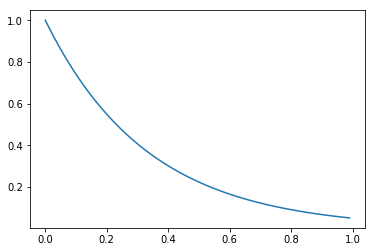

In [859]:
plt.plot([i*0.01 for i in range(100)], [np.exp(-3*i*0.01) for i in range(100)])
plt.show()

In [876]:
def run_RL(initial_genotypes, batch_size, generations, sampling_method):
    noisy_landscape_RL.reset()
    noisy_landscape_RL.measure_true_landscape(initial_genotypes)
    noisy_landscape_RL.natural_mode=False
    noisy_landscape_RL.local_mode=False
    noisy_landscape_RL.cost
    agent = RL_agent_QN(noisy_landscape_RL,wt,alphabet=RAA,memory_size=10000, device=device)
    observations=[x for x in initial_genotypes]
    agent.train_actor(noisy_landscape_RL,observations, train_epochs=10)
    new_sequences = sorted([(noisy_landscape_RL.get_fitness(observations[i]),observations[i])
                            for i in range(len(observations))])
#     agent.memory = new_sequences
    print (noisy_landscape_RL.cost, new_sequences[-1][0])#, avg_loss)
    
    RL_top_seqs = []
    while noisy_landscape_RL.cost<batch_size*generations:
        if (sampling_method == 'eps' or sampling_method == 'multi_eps'):
            eps = 0.1+0.5*np.exp(-3*noisy_landscape_RL.cost / (batch_size * generations))
                    #max(0.1,1-2*noisy_landscape_RL.cost / (batch_size * generations)) #max(0.2,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
            method = (sampling_method, eps)
            
            b = 0
            new = []
            cost_start = noisy_landscape_RL.cost
            # get b new mutations
            while(noisy_landscape_RL.cost < cost_start + batch_size):
                s = agent.pick_action(method)
                if not s in noisy_landscape_RL.measured_sequences.keys():# and not s in new:
                    new.append(s)
                noisy_landscape_RL.measure_true_landscape([s])
            # measure true fitness of these mutations
    #         noisy_landscape_RL.measure_true_landscape(new)
            observations += new
            new_sequences += [(noisy_landscape_RL.get_fitness(new[i]),new[i]) for i in range(len(new))]
            new_sequences = sorted(new_sequences)

            # train
            avg_loss = agent.train_actor(noisy_landscape_RL,observations, train_epochs=20)

            # print best mutation
            print (noisy_landscape_RL.cost, new_sequences[-1][0], avg_loss)

            RL_top_seqs += [(noisy_landscape_RL.cost, new_sequences[-1][0])]
        
        elif (sampling_method.split('.')[0] == 'rollout'):
            eps = 0.1+0.5*np.exp(-3*noisy_landscape_RL.cost / (batch_size * generations))
                         #max(0.1,1-2*noisy_landscape_RL.cost / (batch_size * generations)) #max(0.2,(0.5 - 2*noisy_landscape_RL.cost / (batch_size * generations)))
            k = int(sampling_method.split('.')[1])
            d = int(sampling_method.split('.')[2])
            method = ('rollout', eps, k, d)
            new = []
            cost_start = noisy_landscape_RL.cost
            samples = agent.pick_action_batch(method, batch_size)
            ix = 0
            while(noisy_landscape_RL.cost < cost_start + batch_size):
                s = samples[ix][0] if random.random() > eps and ix < len(samples) else agent.pick_action(('eps',eps))
#                 s = samples[np.random.int(0,len(samples)-1)][1] if random.random() < eps else agent.memory[ix][1]
                if not s in noisy_landscape_RL.measured_sequences.keys() and not s in new:
                    new.append(s)
#                     print(ix)
                    noisy_landscape_RL.measure_true_landscape([s])
                ix += 1
            # measure true fitness of these mutations
            observations += new
            new_sequences += [(noisy_landscape_RL.get_fitness(new[i]),new[i]) for i in range(len(new))]
#             print ([x[0] for x in new_sequences])
            new_sequences = sorted(new_sequences)

            # train
            avg_loss = agent.train_actor(noisy_landscape_RL,observations, train_epochs=20)

            # print best mutation and move state there
            print (noisy_landscape_RL.cost, new_sequences[-1][0], avg_loss)
            agent.state = translate_string_to_one_hot(new_sequences[-1][1],agent.alphabet)

            RL_top_seqs += [(noisy_landscape_RL.cost, new_sequences[-1][0])]
            
            
    return RL_top_seqs


In [878]:
batch_size = 50
generations = 10
RL_data = run_RL(initial_genotypes, batch_size, generations, 'rollout.20.5')

10 0.09647058599135455
60 0.18000000224393956 0.00673231715336442
110 0.19411764705882353 0.002275396045297384
160 0.2552941266228171 0.0027023333124816416
210 0.26823528514188877 0.004600208019837737
260 0.36705883250517 0.007736112363636494
310 0.4117647058823529 0.009103940008208156
360 0.4176470588235294 0.011256410647183657
410 0.4176470588235294 0.011765931686386465
460 0.4176470588235294 0.012323042144998908
510 0.4176470588235294 0.012926207389682531


In [899]:
def compare_diff_parameters(batch_size, generations):
    top_seqs = {}
    top_seqs['CE'] = run_CE(initial_genotypes, batch_size, generations)
    top_seqs['RL_eps'] = run_RL(initial_genotypes, batch_size, generations, "eps")
#     top_seqs['RL_rollout2_k20_d2'] = run_RL(initial_genotypes, batch_size, generations, "rollout.20.2")
    top_seqs['RL_rollout3_k20_d5'] = run_RL(initial_genotypes, batch_size, generations, "rollout.20.5")
#     top_seqs['RL_rollout2_k7_d4'] = run_RL(initial_genotypes, batch_size, generations, "rollout.7.4")
#     top_seqs['RL_rollout2_k3_d7'] = run_RL(initial_genotypes, batch_size, generations, "rollout.3.7")
    return top_seqs

In [ ]:
for sim in range(10):
    for batch_size, generations in [(1000,10)]:#[(10,10),(50,10),(100,10)]:#,(1000,10)]:
        print("Sim: {}, Batch size: {}, Generations: {}".format(sim, batch_size, generations))
        top_seqs = compare_diff_parameters(batch_size, generations)
        np.save('./simulations/CE/batch{batch_size}_generations{generations}_{sim}'.format(
            batch_size=batch_size, generations=generations, sim=sim), top_seqs['CE'])
        for explorer in ['RL_eps', 'RL_rollout3_k20_d5']:
            np.save('./simulations/RL/{sampling}_batch{batch_size}_generations{generations}_{sim}'.format(
            sampling=explorer[3:],batch_size=batch_size, generations=generations, sim=sim), 
                    top_seqs[explorer])

Sim: 0, Batch size: 1000, Generations: 10
10 0.09647058599135455
160 0.14588234845329734
1160 0.28470589132869945
2160 0.28470589132869945
3160 0.2905882442698759
4160 0.33882352043600644
5160 0.38235294117647056
6160 0.3941176470588235
7160 0.421176461612477
8160 0.4235294117647059
9160 0.4658823349896599
10160 0.4729411854463465
10 0.09647058599135455
1010 0.15411765154670268 0.0032347057131119072
2010 0.1588235294117647 0.001042912426055409
3010 0.21882353389964385 0.0016234956216067075
4010 0.24588234845329734 0.001822294620797038
5010 0.24588234845329734 0.0017235942708794028
6010 0.2529411764705882 0.0018227325344923884
7010 0.25764705433565027 0.0019329326401930302
8010 0.25882352941176473 0.0018723543791566045
9010 0.25882352941176473 0.0018995288468431682
10010 0.25882352941176473 0.001855286327190697
10 0.09647058599135455
1010 0.23999999551212087 0.003946721064858138
2010 0.26705883250517004 0.002754692151211202
3010 0.32588236191693476 0.004222423583269119
4010 0.3576470543

In [ ]:
batch_size = 1000
generations = 10
f,ax = plt.subplots(1,1,figsize=(6,4))
plt.xlabel("cost")
plt.ylabel("maximum fitness observed")

for sampling,explorer,label in [('','CE','CE'), ('eps_','RL','RL_eps'), 
                                ('rollout3_k20_d5_', 'RL','RL_rollout3_k20_d5')]:#, 
#                                 ('rollout2_k7_d4_', 'RL', 'RL_rollout2_k7_d4'),
#                                ('rollout2_k10_d3_', 'RL', 'RL_rollout2_k10_d3'),
#                                ('rollout2_k20_d2_', 'RL', 'RL_rollout2_k20_d2')]:
    data_explorer = pd.DataFrame(columns = ['cost', explorer])
    for sim in range(10):
        top_seqs_explorer = np.load('./simulations/{explorer}/{sampling}batch{batch_size}_generations{generations}_{sim}.npy'.format(
                explorer=explorer,sampling=sampling, batch_size=batch_size, generations=generations, sim=sim))
#         print(top_seqs_explorer)
        data_explorer = data_explorer.append(pd.DataFrame(data=np.array([[s[0] for s in top_seqs_explorer if s[0] <= batch_size*generations],
                                                                         [s[1] for s in top_seqs_explorer if s[0] <= batch_size*generations]]).T, 
                                         columns = ['cost', explorer]))

#     print(data_explorer)
    data_explorer = data_explorer.sort_values('cost')#.rolling(10).mean()
#     data_explorer.plot(x='cost',y=explorer, ax = ax)
    sns.lineplot(x='cost',y=explorer,data=data_explorer, label=label, ci = 'sd')
plt.legend()
plt.title("Batch Size={batch_size}, Generations={generations}".format(
    batch_size=batch_size, generations=generations))
plt.tight_layout()
plt.show()
f.savefig('./figs/comparison_CE_eps_rollout3_batch{batch}_generations{generations}.png'.format(batch=batch_size,
                                                                                         generations=generations))

# MULTI AGENT RL

In [38]:
import random

class RL_multi_agent_QN():
    def __init__(self,agent_type,landscape,wt,alphabet, pop_size,memory_size=1200,best_seq_prop=1):
        self.memory=[]
        self.pop_size=pop_size
        self.alphabet=alphabet
        self.wt=wt
        self.agents=[agent_type(self.wt,self.alphabet) for i in range(self.pop_size)]
        self.memory_size=memory_size
        self.memory=[]
        self.landscape=landscape
        self.best_seqs=[]
        self.best_seqs_len=self.pop_size*best_seq_prop

    def add_to_top_seqs(self,sequence):
        fitness= self.landscape.get_fitness(sequence)
        if len(self.best_seqs)<self.best_seqs_len:
            self.best_seqs.append((fitness,sequence))

        else:
            if fitness > self.best_seqs[0][0] and (fitness,sequence) not in self.best_seqs:
                self.best_seqs.append((fitness,sequence))
                self.best_seqs=sorted(self.best_seqs)
                self.best_seqs=self.best_seqs[1:]

    def reset_position(self,sequence):
        for agent in self.agents:
            agent.reset_position(sequence)

    def observe(self, num_observations=1000, costly=False, depth=10):
        for agent in self.agents:
            observations=agent.observe(self.landscape,[generate_random_mutant(agent.get_position(),0.1,self.alphabet) for i in range(num_observations)],costly=True,depth=depth)
            self.memory.extend(observations)
        if len(self.memory)>self.memory_size:
            self.memory=random.sample(self.memory,self.memory_size)
            
    def force_observations(self, observations):
        num_agents = len(self.agents)
        for agent in self.agents:
            agent.memory.extend(observations)
            if len(agent.memory) > agent.memory_size:
                agent.memory = random.sample(agent.memory, agent.memory_size)

    def train_agents(self, observations):
        total_loss = 0.0
        for agent in self.agents:
            total_loss += agent.train_actor(self.landscape, observations, train_epochs=20)
        return total_loss/len(self.agents)

    def cross_train_agents(self, observations, num_x_obs=1000):
        total_loss = 0.0
        for agent in self.agents:
            total_loss += agent.xtrain_actor(self.landscape, random.sample(observations,num_x_obs), train_size=max(len(observations), num_x_obs), train_epochs=20)
        return total_loss/len(self.agents)

    def pick_action(self, method):
        self.sequences=[]
        sequences=[]
        for agent_id, agent in enumerate(self.agents):
            action = agent.pick_action(method)
            self.sequences.append(action)
            sequences.append((action, agent_id))
#             self.memory.extend(agent.memory)

#         if len(self.memory)>self.memory_size:
#             self.memory=random.sample(self.memory,self.memory_size)

        for seq in self.sequences:
            self.add_to_top_seqs(seq)

        return sequences

In [39]:
def run_RL_multi_agent(initial_genotypes, batch_size, generations, sampling_method, num_agents=10):
    noisy_landscape_RL_multiple.reset()
    noisy_landscape_RL_multiple.measure_true_landscape(initial_genotypes)
    noisy_landscape_RL_multiple.natural_mode=False
    noisy_landscape_RL_multiple.local_mode=False
    noisy_landscape_RL_multiple.cost

    multi_agents = RL_multi_agent_QN(RL_agent_QN,
                              noisy_landscape_RL_multiple,
                              wt,
                              RAA,
                              num_agents,
                              memory_size=batch_size)

    # set the SAME initial position for each
    for i in range(num_agents):
        multi_agents.agents[i].reset_position(initial_genotypes[0])

    # keep separate list of observations for each agent
    observations = [[x for x in initial_genotypes] for i in range(num_agents)]
    new_sequences = sorted([(noisy_landscape_RL_multiple.get_fitness(observations[i]),[observations[i]])
                            for i in range(len(observations))])

    multi_RL_top_seqs = []
    
    while noisy_landscape_RL_multiple.cost < batch_size * generations:
        if (sampling_method == 'eps'):
            eps = max(0.2,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
            method = (sampling_method, eps)
        elif (sampling_method == 'multi_eps'):
            eps = max(0.2,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
            method = (sampling_method, eps)
        elif (sampling_method == 'rollout'):
            eps = max(0.2,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
            method = (sampling_method, eps)
        else:
            method = (sampling_method,)
        
        # DOESN'T WORK: goal; train each agent on their own observations, and a subsample of other agents observations
        b = 0
        new = []
        new_indices = []
        while(b < batch_size):
            seqs = multi_agents.pick_action(method)
            for s in seqs:
                if not s[0] in noisy_landscape_RL_multiple.measured_sequences.keys():
                    new += [s[0]]
                    new_indices += [s[1]]
                    b += 1

        noisy_landscape_RL_multiple.measure_true_landscape(new)
        observations += new
    #     multi_agents.force_observations(observations)
        avg_loss = multi_agents.train_agents(observations)
        print(noisy_landscape_RL_multiple.cost, noisy_landscape_RL_multiple.get_fitness(new_sequences[-1][1][0]), avg_loss)
        new_sequences += [(noisy_landscape_RL_multiple.get_fitness(new[i]),[new[i]]) for i in range(len(new))]
        new_sequences = sorted(new_sequences)
        multi_RL_top_seqs += [(noisy_landscape_RL_multiple.cost, new_sequences[-1][0])]
        
    return multi_RL_top_seqs

In [215]:
batch_size = 10
generations = 10
num_agents = 2
RL_data = run_RL_multi_agent(initial_genotypes, batch_size, generations, 'multi_eps', num_agents)

20 0.12823528962976793 0.012512424145825207
30 0.1411764705882353 0.0030382839759113267
40 0.1411764705882353 0.0010462194797582923
50 0.16823529636158663 0.0009342695659142919
58 0.19529412213493796 0.0009595630734111182
67 0.24235294566434973 0.001135399741178844
75 0.28705881904153263 0.001163351938885171
85 0.3729411854463465 0.0011376501337508672
92 0.3729411854463465 0.0008774404850555584
100 0.3729411854463465 0.0012642273897654375
